# Requirements

In [6]:
import unicodedata, string, re, random, time, math, torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import keras, numpy as np

Using TensorFlow backend.


In [7]:
from keras.preprocessing import sequence

## Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download to `data/fra.txt` before continuing. The file is a tab separated list of translation pairs:

```
I am cold.    Je suis froid.
```

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [8]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [9]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [10]:
def readLangs(lang1, lang2, pairs_file, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s' % (pairs_file)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).

In [11]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [13]:
def prepareData(lang1, lang2, pairs_file, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs_file, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', 'fra.txt', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['il est respecte par tout le monde .', 'he is respected by everyone .']


In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]+[EOS_token]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    return Variable(torch.LongTensor(indexes).unsqueeze(0))

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [15]:
def index_and_pad(lang, dat):
    return sequence.pad_sequences([indexesFromSentence(lang, s) 
                                  for s in dat], padding='post').astype(np.int64)

In [16]:
fra, eng = list(zip(*pairs))

In [17]:
fra = index_and_pad(input_lang, fra)
eng = index_and_pad(output_lang, eng)

In [18]:
def get_batch(x, y, batch_size=16):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

## The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=n_layers)
        
    def forward(self, input, hidden):
        output, hidden = self.gru(self.embedding(input), hidden)
        return output, hidden

    # TODO: other inits
    def initHidden(self, batch_size):
        return Variable(torch.zeros(1, batch_size, self.hidden_size))

## Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the *context vector* as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<SOS>` token, and the first hidden state is the context vector (the encoder's last hidden state).

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=n_layers)
        # TODO use transpose of embedding
        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        emb = self.embedding(input).unsqueeze(1)
        # NB: Removed relu
        res, hidden = self.gru(emb, hidden)
        output = self.sm(self.out(res[:,0]))
        return output, hidden

## Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. 

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs. First we calculate a set of *attention weights*. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called `attn_applied` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward layer `attn`, using the decoder's input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![](images/attention-decoder-network.png)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

*Note:* There are other forms of attention that work around the length limitation by using a  relative position approach. Read about "local attention" in [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025).

## Training

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<SOS>` token as its first input, and the last hidden state of the decoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as each next input, instead of using the decoder's guess as the next input. Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

In [21]:
def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          
                #, encoder_output, encoder_outputs)
        targ = target_variable[:, di]
#         print(decoder_output.size(), targ.size(), target_variable.size())
        loss += criterion(decoder_output, targ)
        decoder_input = targ

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [22]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [23]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, 
                learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.RMSprop(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.RMSprop(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss().cuda()
    
    for epoch in range(1, n_epochs + 1):
        training_batch = get_batch(fra, eng)
        input_variable = Variable(torch.LongTensor(training_batch[0])).cuda()
        target_variable = Variable(torch.LongTensor(training_batch[1])).cuda()
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, 
                                         epoch / n_epochs * 100, print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

### Attention

In [141]:
# TODO: Make this change during training
teacher_forcing_ratio = 0.5

def attn_train(input_variable, target_variable, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

# Plotting results

Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder's predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder's attention outputs for display later.

In [25]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence).cuda()
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden(1).cuda()
    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)

    decoder_input = Variable(torch.LongTensor([SOS_token])).cuda()
    decoder_hidden = encoder_hidden
    
    decoded_words = []
#     decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
#         decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        #, encoder_output, encoder_outputs)
#         decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        decoder_input = Variable(torch.LongTensor([ni])).cuda()
    
    return decoded_words,0#, decoder_attentions[:di+1]

In [27]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training and Evaluating

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. Comment out the lines where the encoder and decoder are initialized and run `trainEpochs` again.

In [28]:
#TODO:
# - Test set
# - random teacher forcing
# - attention
# - multi layers
# - bidirectional encoding

In [29]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).cuda()
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words).cuda()

In [30]:
trainEpochs(encoder1, attn_decoder1, 15000, print_every=500, learning_rate=0.005)

0m 10s (- 5m 13s) (500 3%) 1.6385


KeyboardInterrupt: 

In [107]:
evaluateRandomly(encoder1, attn_decoder1)

> c est un ecrivain talentueux .
= he s a talented writer .
< he s a talented writer . <EOS>

> en realite il n est pas l impresario .
= he is actually not the manager .
< he is actually not the manager . <EOS>

> vous etes le dernier espoir de l humanite .
= you re the last hope for humanity .
< you re the last hope for humanity . <EOS>

> je me fais des soucis pour sa securite .
= i am concerned for her safety .
< i m concerned with my new light . <EOS>

> je ne vais pas mentir .
= i m not going to lie .
< i m not going to do my not gonna up

> vous etes fort courageuse .
= you re very brave .
< you re very brave . <EOS>

> nous sommes contents que vous soyez la .
= we re glad you re here .
< we re glad you re here . <EOS>

> vous etes incroyablement talentueuses .
= you re incredibly talented .
< you re incredibly talented . <EOS>

> je suis a court d idees .
= i m out of ideas .
< i m the tallest one of them . <EOS>

> tu le fais comme il faut .
= you re doing it right .
< you re d

## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

NOTE: This only works when using the attentional decoder, if you've been following the notebook to this point you are using the standard decoder.

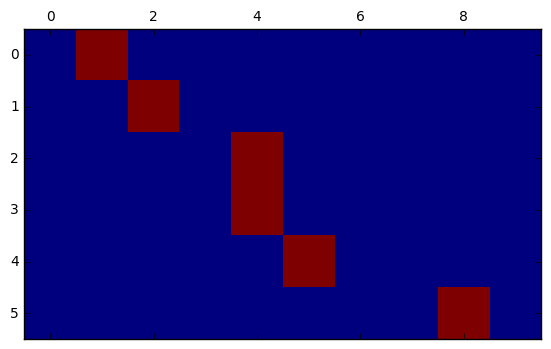

In [20]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


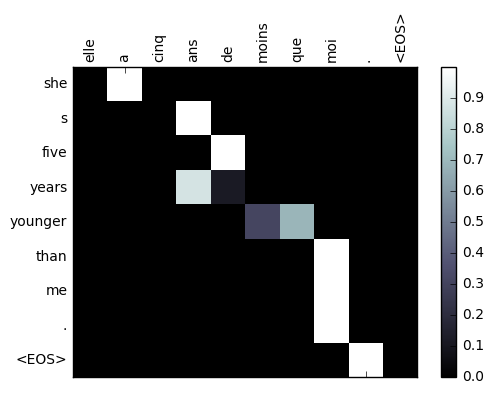

In [22]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she is never short . <EOS>


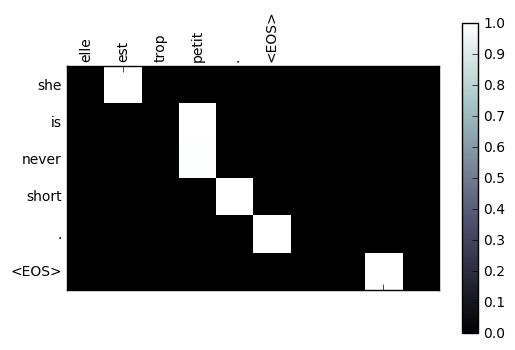

In [23]:
evaluateAndShowAttention("elle est trop petit .")

input = je ne crains pas de mourir .
output = i m not scared of that . <EOS>


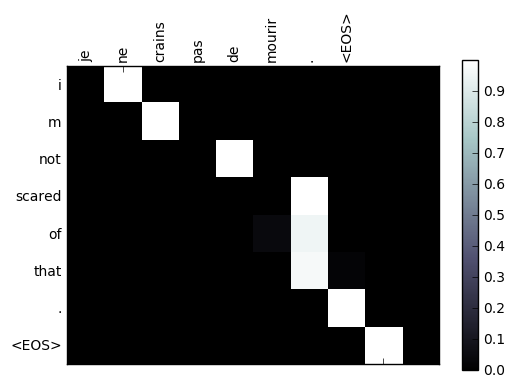

In [24]:
evaluateAndShowAttention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he s a talented young man . <EOS>


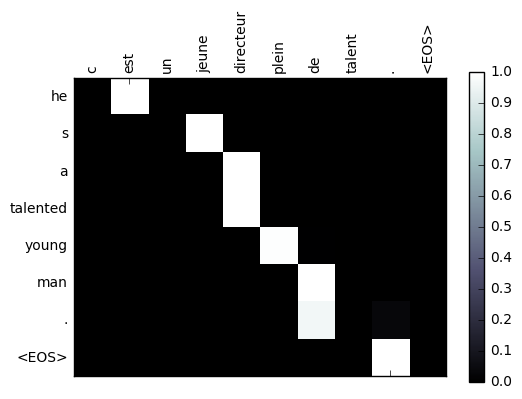

In [25]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

* Replace the embedding pre-trained word embeddings such as word2vec or GloVe